# 1.0 Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from random import randint
from random import uniform

from scipy import stats

import matplotlib.pyplot as plt
# import plotly.express as px
import plotly.graph_objects as go
from PIL import Image
from IPython.display import display
 

from sklearn.model_selection import train_test_split
from boruta import BorutaPy
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.utils import resample

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from category_encoders import TargetEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import RobustScaler


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

import joblib

import warnings
warnings.filterwarnings("ignore")

# 2.0 Loading data

In [2]:
df_raw = pd.read_csv('data/dataset.csv')
df_raw

,Age,service_subscription_time,paid_value_monthly,accessed_items,Churn
0,62,31,54.19,19,False
1,65,3,74.58,18,False
2,18,20,76.43,10,False
3,21,4,91.58,2,False
4,21,14,81.99,16,True
...,...,...,...,...,...
995,33,22,14.90,0,False
996,38,15,27.21,11,False
997,27,14,64.36,16,False
998,22,4,69.60,8,False


In [3]:
df_raw['Churn'] = [1 if value == True else 0 for value in df_raw['Churn']]

df_raw

,Age,service_subscription_time,paid_value_monthly,accessed_items,Churn
0,62,31,54.19,19,0
1,65,3,74.58,18,0
2,18,20,76.43,10,0
3,21,4,91.58,2,0
4,21,14,81.99,16,1
...,...,...,...,...,...
995,33,22,14.90,0,0
996,38,15,27.21,11,0
997,27,14,64.36,16,0
998,22,4,69.60,8,0


# 3.0 Split into train and test data

In [4]:
X = df_raw.drop('Churn', axis=1)
y = df_raw[['Churn']]

In [5]:
test_size = 0.2
seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [6]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (800, 4)
y_train: (800, 1)
X_test: (200, 4)
y_test: (200, 1)


In [7]:
df_raw2 = pd.concat([X_train, y_train], axis=1)


# 4.0 EDA - Exploratory Data Analisys

In [8]:
df_raw2.shape

(800, 5)

In [9]:
df_raw2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 29 to 102
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        800 non-null    int64  
 1   service_subscription_time  800 non-null    int64  
 2   paid_value_monthly         800 non-null    float64
 3   accessed_items             800 non-null    int64  
 4   Churn                      800 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 37.5 KB


In [10]:
df_raw2['Churn'].value_counts()

Churn
0    560
1    240
Name: count, dtype: int64

In [11]:
df_raw2.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,800.0,40.760000,13.955675,18.00,28.00,41.00,53.0000,65.00
service_subscription_time,800.0,18.293750,10.238090,1.00,9.00,18.00,27.0000,36.00
paid_value_monthly,800.0,55.171788,25.932619,10.03,33.09,55.82,77.3725,99.85
accessed_items,800.0,9.516250,6.061614,0.00,4.00,9.00,15.0000,20.00
Churn,800.0,0.300000,0.458544,0.00,0.00,0.00,1.0000,1.00


<Axes: xlabel='Churn', ylabel='Age'>

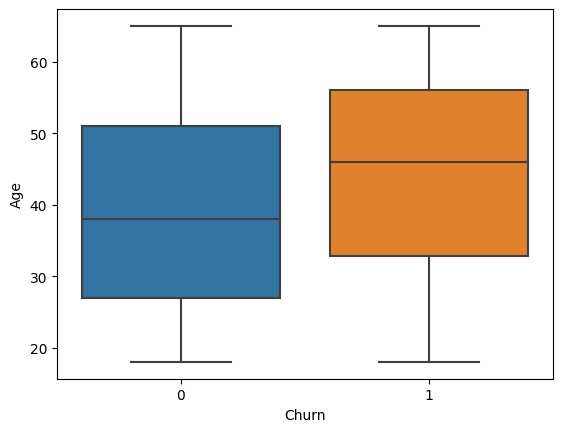

In [12]:
sns.boxplot(data=df_raw2, y='Age', x='Churn')

<Axes: xlabel='Churn', ylabel='service_subscription_time'>

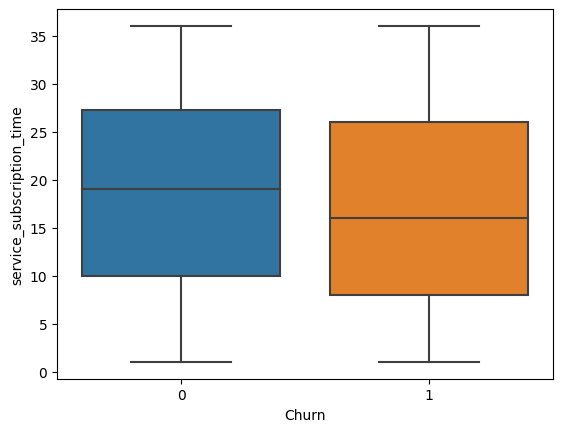

In [13]:
sns.boxplot(data=df_raw2, y='service_subscription_time', x='Churn')

<Axes: xlabel='Churn', ylabel='paid_value_monthly'>

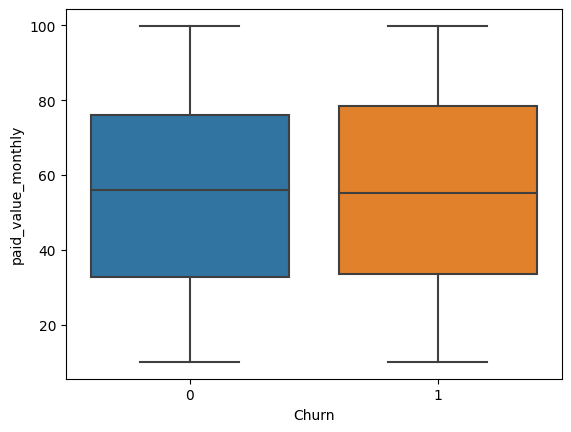

In [14]:
sns.boxplot(data=df_raw2, y='paid_value_monthly', x='Churn')

<Axes: xlabel='Churn', ylabel='accessed_items'>

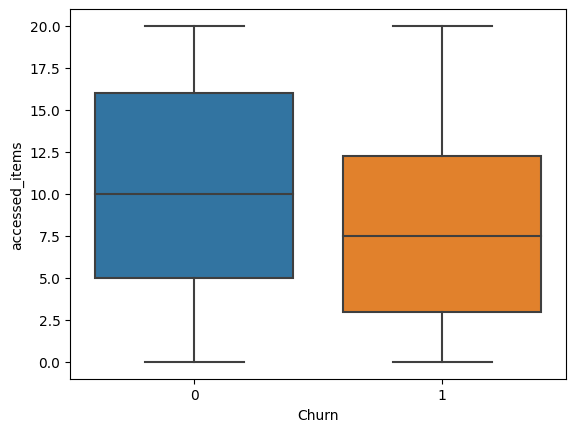

In [15]:
sns.boxplot(data=df_raw2, y='accessed_items', x='Churn')

# 5.0 Preprocessing

In [16]:
def test_stat(df, statistical_significance):
    cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    list_cols = []

    for col in cols:
        p_value = stats.shapiro(df[col])[1]
        if p_value <= statistical_significance:
            list_cols.append(col)

    return list_cols

In [17]:
print(f"We have {len(test_stat(X_train, 0.05))} features with normal distribuition")
print()
print(test_stat(X_train, 0.05))

We have 4 features with normal distribuition

['Age', 'service_subscription_time', 'paid_value_monthly', 'accessed_items']


In [18]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

# 6.0 Models

In [24]:
model_lr = LogisticRegression(random_state = seed)
model_dt = DecisionTreeClassifier(random_state = seed)
model_rf = RandomForestClassifier(random_state = seed)
model_svm = SVC(random_state = seed)
model_nb = GaussianNB()
model_xgb = XGBClassifier(random_state = seed)
model_gb = GradientBoostingClassifier(random_state = seed)
model_ada = AdaBoostClassifier(random_state = seed)

models = [
    model_lr, 
    model_dt, 
    model_rf, 
    model_svm, 
    model_nb, 
    model_xgb, 
    model_gb, 
    model_ada
]

name = [
    'Logistic Regression', 
    'Decision Tree', 
    'Random Forest', 
    'SVC', 
    'Naive Bayes', 
    'XGBoost', 
    'Gradient Boosting', 
    'AdaBoost Classifier'
]


columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1']
metric_df = pd.DataFrame(columns=columns)


for i in range(len(models)):

    model = models[i]
    model.fit(X_train_scaled, y_train)

    score_model = model.score(X_test_scaled, y_test)
    y_pred = model.predict(X_test_scaled)
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    metric = {
        'Model': [name[i]],
        'Accuracy': [score_model],
        'Precision': [model_precision],
        'Recall': [model_recall],
        'F1': [f1]
    }

    metric_temp = pd.DataFrame(metric)
    
    metric_df = pd.concat([metric_df, metric_temp], ignore_index=True)
    

metric_df = metric_df[columns]
    
metric_df

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.725,0.428571,0.055556,0.468059
1,Decision Tree,0.640,0.350000,0.388889,0.558336
2,Random Forest,0.685,0.378378,0.259259,0.551904
3,SVC,0.725,0.000000,0.000000,0.420290
4,Naive Bayes,0.720,0.333333,0.037037,0.450980
5,XGBoost,0.695,0.414634,0.314815,0.578947
6,Gradient Boosting,0.695,0.347826,0.148148,0.509469
7,AdaBoost Classifier,0.665,0.259259,0.129630,0.481404


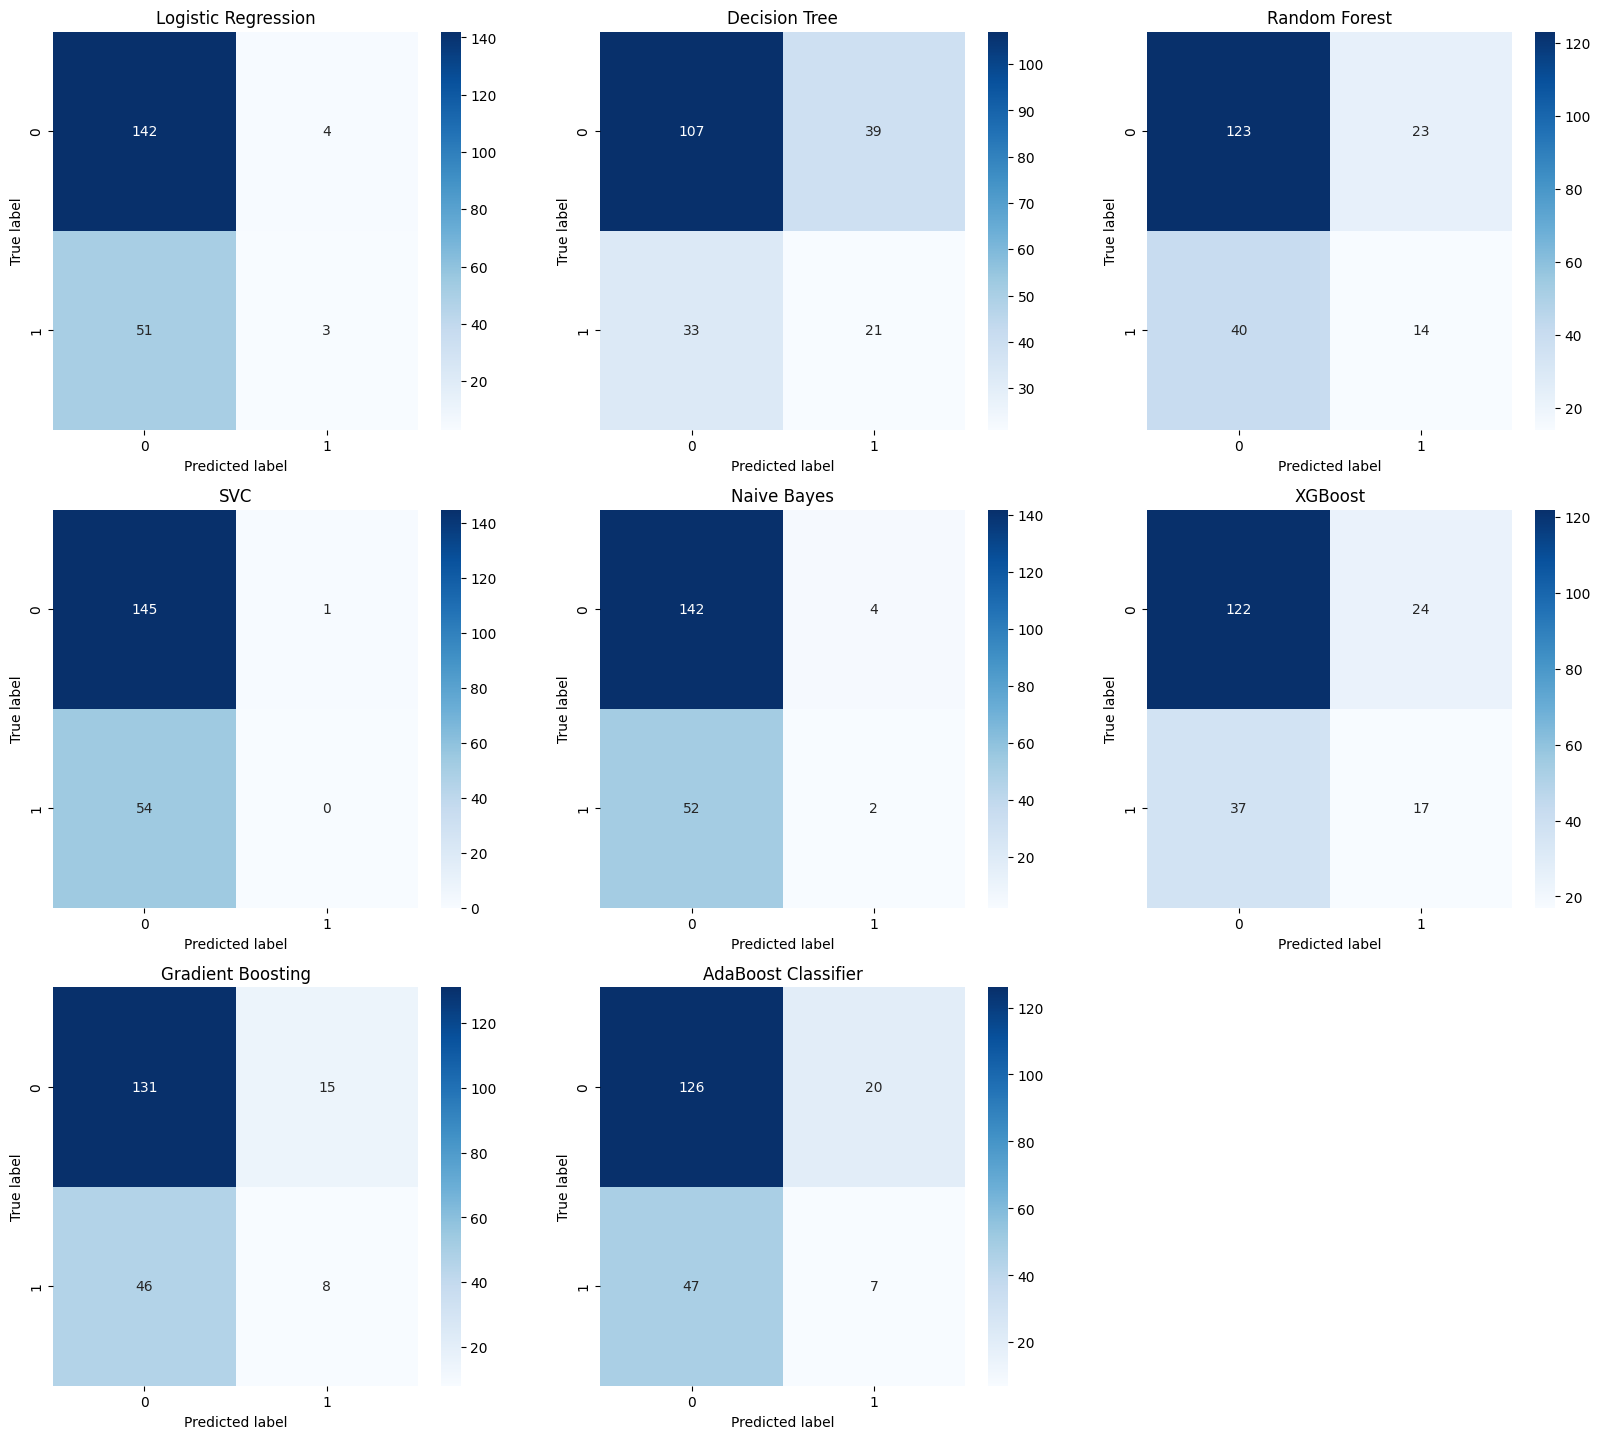

In [25]:
plt.figure(figsize = (20, 30))

for i in range(len(models)):    
    model = models[i]
    model.fit(X_train_scaled, y_train)

    score_model = model.score(X_test_scaled, y_test)
    y_pred = model.predict(X_test_scaled)
                           
    
    plt.subplot(5, 3, i + 1)

    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    plt.title(name[i])
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    
plt.show()

In [31]:
model_xgb = XGBClassifier(random_state = seed)

model_xgb.fit(X_train_scaled, y_train)

score_model = model_xgb.score(X_test_scaled, y_test)
y_pred = model_xgb.predict(X_test_scaled)
model_precision = precision_score(y_test, y_pred)
model_recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

metric = {
    'Model': 'XGBoost',
    'Accuracy': [score_model],
    'Precision': [model_precision],
    'Recall': [model_recall],
    'F1': [f1]
}

metric_df = pd.DataFrame(metric)

metric_df

,Model,Accuracy,Precision,Recall,F1
0,XGBoost,0.695,0.414634,0.314815,0.578947
